# Summary

Test new `get_databunch` functionality to allow for supervised task.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
                            precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from img_wang.data import load_img, get_databunch, ds_subset
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, std_soft_prediction, \
    percent_positive

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [3]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


## Load Supervised DS

In [50]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', mode='supervised',
                                   bs=9, max_train_len=18, max_val_len=18)

In [51]:
lmap(len, dst, dsv, dlt, dlv)

[18, 18, 2, 2]

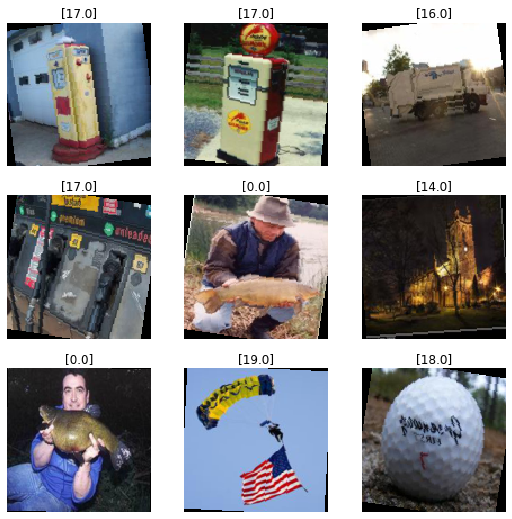

In [52]:
xb, yb = next(iter(dlt))
show_images(xb, nrows=3, titles=yb.tolist())

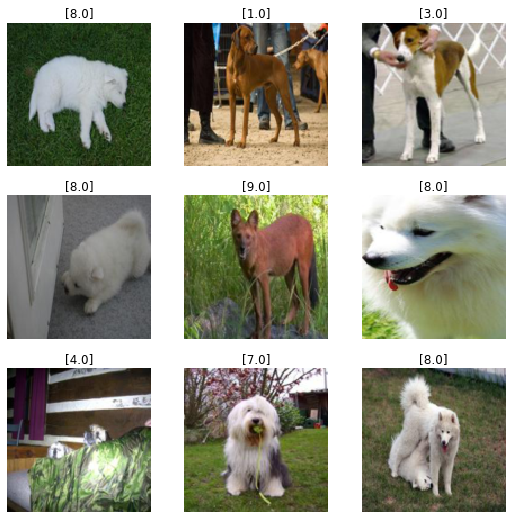

In [53]:
xb, yb = next(iter(dlv))
show_images(xb, nrows=3, titles=yb.tolist())

In [8]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('resnext101_32x8d', pretrained=False)
)

In [35]:
net.eval()

SingleInputBinaryModel(
  (groups): Sequential(
    (0): TorchvisionEncoder(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [38]:
net.predict(xb)

tensor([[-0.3434],
        [-0.3454],
        [-0.3395],
        [-0.3421],
        [-0.3418],
        [-0.3412],
        [-0.3376],
        [-0.3382],
        [-0.3414]])

In [55]:
yb

tensor([[8.],
        [1.],
        [3.],
        [8.],
        [9.],
        [8.],
        [4.],
        [7.],
        [8.]])

In [15]:
xb.dtype

torch.float32

In [56]:
F.binary_cross_entropy_with_logits(net(xb), yb)

tensor(2.6653, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [45]:
yb

tensor([7, 6, 7, 0, 9, 1, 6, 1, 6])

In [40]:
F.binary_cross_entropy_with_logits(net(xb), yb.unsqueeze(-1).float(), reduction='none')

tensor([[2.9399],
        [2.6079],
        [2.9140],
        [0.5367],
        [3.6130],
        [0.8782],
        [2.5644],
        [0.8765],
        [2.5852]], grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [42]:
torch.tensor([[2.9399],
        [2.6079],
        [2.9140],
        [0.5367],
        [3.6130],
        [0.8782],
        [2.5644],
        [0.8765],
        [2.5852]]).mean()

tensor(2.1684)

In [100]:
def load_encoder(net, enc_version):
    state = torch.load(f'data/models/{enc_version}/trainer.pkl')
    enc_state = {k: v for k, v in state['model'].items()
                 if k.split('.')[1] == '0'}
    net.load_state_dict(enc_state, strict=False)
    return net

In [101]:
net.groups[0].weight_stats()[:10]

[(0.0, 0.025),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.088),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.029),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.089)]

In [102]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(1.2280e-05, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(-0.0006, grad_fn=<MeanBackward0>)]

In [103]:
net = load_encoder(net, 'v7')

In [104]:
net.groups[0].weight_stats()[:10]

[(-0.001, 0.04),
 (0.991, 0.065),
 (0.023, 0.072),
 (-0.0, 0.094),
 (1.0, 0.035),
 (-0.003, 0.035),
 (-0.001, 0.042),
 (0.999, 0.035),
 (-0.003, 0.029),
 (-0.001, 0.092)]

In [105]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(1.2280e-05, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(-0.0006, grad_fn=<MeanBackward0>)]

## Scratch

In [95]:
# new_state = net.groups[0].state_dict()
new_state = net.state_dict()

In [76]:
state = torch.load('data/models/v7/trainer.pkl')

In [89]:
# enc_state = {k.replace('groups.0.', ''): v 
#              for k, v in state['model'].items() if k.split('.')[1] == '0'}
enc_state = {k: v for k, v in state['model'].items() if k.split('.')[1] == '0'}
# enc_state = {k: v for k, v in state['model'].items() 
#              if k.split('.')[1] == '0' and 'bn' not in k}

In [90]:
len(state['model']), len(enc_state), len(new_state)

(636, 624, 624)

In [91]:
enc_state.keys() == new_state.keys()

False

In [96]:
len(enc_state.keys() - new_state.keys())

0

In [97]:
len(new_state.keys() - enc_state.keys())

12

In [81]:
eprint(list(zip(enc_state, new_state))[:10])

 0: ('model.0.weight', 'model.0.weight')
 1: ('model.1.weight', 'model.1.weight')
 2: ('model.1.bias', 'model.1.bias')
 3: ('model.1.running_mean', 'model.1.running_mean')
 4: ('model.1.running_var', 'model.1.running_var')
 5: ('model.1.num_batches_tracked', 'model.1.num_batches_tracked')
 6: ('model.4.0.conv1.weight', 'model.4.0.conv1.weight')
 7: ('model.4.0.bn1.weight', 'model.4.0.bn1.weight')
 8: ('model.4.0.bn1.bias', 'model.4.0.bn1.bias')
 9: ('model.4.0.bn1.running_mean', 'model.4.0.bn1.running_mean')


In [82]:
net.groups[0].weight_stats()[:15]

[(0.0, 0.026),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.089),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.029),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.001, 0.089),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.087),
 (1.0, 0.0),
 (0.0, 0.0)]

In [84]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(5.0396e-06, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(0.0015, grad_fn=<MeanBackward0>)]

In [85]:
net.groups[0].load_state_dict(enc_state)

<All keys matched successfully>

In [87]:
net.groups[0].weight_stats()[:10]

[(-0.001, 0.04),
 (0.991, 0.065),
 (0.023, 0.072),
 (-0.0, 0.094),
 (1.0, 0.035),
 (-0.003, 0.035),
 (-0.001, 0.042),
 (0.999, 0.035),
 (-0.003, 0.029),
 (-0.001, 0.092)]

In [88]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(5.0396e-06, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(0.0015, grad_fn=<MeanBackward0>)]

In [134]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang'),
                       EarlyStopper('loss', 'min', patience=5)],
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive, 
                     accuracy_score, f1_score, recall_score, precision_score,
                     roc_auc_score])

In [135]:
t.load('trainer.pkl')

2020-09-16 05:47:02,828 [INFO]: Loading weights from data/models/v0/trainer.pkl.
